## Imports

In [ ]:
import torch
from matplotlib import pyplot as plt
from torchvision import datasets, models
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import numpy as np
import collections
import PIL.Image
from torch.utils.data import DataLoader, Subset
import os
import random
from google.colab import drive
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from facenet_pytorch import MTCNN

## Select device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Google Drive Mount and paths

In [ ]:
drive.mount("/content/drive")
root_dir = "/content/drive/My Drive/IA_Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = os.path.join(root_dir, "LFW_DIR")
people_path = os.path.join(root_dir, "data/people.txt")

## Hyperparameters

In [ ]:
# iperparametri
img_size = 224
crop_size = 128
batch_size = 5

## Data Loading

In [ ]:
# image transformation

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
#norm_mean = (0.5, 0.5, 0.5)
#norm_std = (0.5, 0.5, 0.5)

test_transform = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(crop_size),
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

train_transform = T.Compose([
    T.Resize(img_size),
    T.RandomCrop(crop_size),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(norm_mean, norm_std),
])

In [ ]:
# funzione per la lettura della lista [nome_persona, num_immagini] da file .txt
def readPeople(people_path):
  people_list = []
  with open(people_path, 'r') as file:
    for line in file.readlines():
      person = line.strip().split()
      people_list.append(person)
  return people_list

people_list = readPeople(people_path)

In [ ]:
# people_list

In [ ]:
# funzione di filtraggio delle persone in base al numero di immagini nel dataset
# utilizzando la lista di persone precedentemente ricavata
def get_class_images_dict(data_path, people_list):
  class_images_dict = {}
  label = 1

  for person in people_list:
    # prendo tutte le persone che hanno almeno 5 immagini...
    if int(person[1]) >= 5:
      images = []
      # ... e di queste ne prendo solamente le prime 5 
      for img_id in range(1, 5):
        path = os.path.join(data_path, person[0], person[0] + '_' + '%04d' % img_id + '.jpg')
        #images.append(path)
        class_images_dict[path] = label
      label += 1

  # otteniamo un dizionario del tipo { image_path: label}
  return class_images_dict

In [ ]:
class_images_dict = get_class_images_dict(data_path, people_list)

print(f"Numero di immagini: {len(class_images_dict)}")

embed_dim = len(class_images_dict)

Numero di immagini: 1692


In [ ]:
# class_images_dict

In [ ]:
# Prepariamo le frazioni per i tre dataset
list_item = list(class_images_dict.items())
random.shuffle(list_item)
list_item_rand = dict(list_item)

# Dataset fraction
test_frac = 0.2
val_frac = 0.2

# data len
num_data = len(class_images_dict)
num_test = int(num_data*test_frac)
num_val = int(num_data*val_frac)

# split dict in train, test, val
num_data = num_data - num_test
test_items = dict(list(list_item_rand.items())[num_data:]) 
list_item_rand = dict(list(list_item_rand.items())[:num_data])

num_data = num_data - num_val
val_items = dict(list(list_item_rand.items())[num_data:]) 
train_items = dict(list(list_item_rand.items())[:num_data])

In [ ]:
# a questo punto abbiamo tre dizionari che poi utilizzeremo per creare i nostri dataset
# eseguiamo ora un controllo per fare in modo che non vi siano label spaiate
def del_umpaired_images(dataset_dict):
  rev_dict = {}
  for key,value in dataset_dict.items():
    # inverto key e value del dizionario passato in argomento 
    rev_dict.setdefault(value, set()).add(key)
    # prendo ora le key che abbiamo solo una volta
    single_labels = [key for key, values in rev_dict.items() if len(values) == 1] 
  
  print(f"Dataset lenght before: {len(dataset_dict)}")
  for item in single_labels:
    # abbiamo usato un set per il rev dict che non so perché mi smichia gli elementi
    # quindi ci calo un malu join e mi recupero la key per eliminare l'elemento dal dict
    key = "".join(rev_dict[item])
    del dataset_dict[key]

  print(f"Dataset lenght after: {len(dataset_dict)}")
  return dataset_dict

In [ ]:
print("Train:")
train_items = del_umpaired_images(train_items)
print("Test:")
test_items = del_umpaired_images(test_items)
print("Val:")
val_items = del_umpaired_images(val_items)

Train:
Dataset lenght before: 1016
Dataset lenght after: 953
Test:
Dataset lenght before: 338
Dataset lenght after: 147
Val:
Dataset lenght before: 338
Dataset lenght after: 168


In [ ]:
print(f" number of train samples: {len(train_items)}\n",
      f"number of val samples: {len(val_items)}\n",
      f"number if test samples: {len(test_items)}")

 number of train samples: 953
 number of val samples: 168
 number if test samples: 147


In [ ]:
class LFWDataset(torch.utils.data.Dataset):

  def __init__(self, class_images_dict, transform=None):
    self.transform = transform
    self.class_images_dict = class_images_dict
    self.list_of_tuples = self.get_list_of_tuples(self.class_images_dict)

  # serve dopo per il getitem
  def get_list_of_tuples(self, class_images_dict):
    list_of_tuples = [(k, v) for k, v in class_images_dict.items()] 
    return list_of_tuples
    
  def __len__(self):
    return len(self.list_of_tuples)

  def __getitem__(self, index):
    img_path, label = self.list_of_tuples[index]
    img = PIL.Image.open(img_path)

    if self.transform:
      img = self.transform(img)

    return img, label

In [ ]:
# get datasets
train_dataset = LFWDataset(train_items, transform=train_transform)
test_dataset = LFWDataset(test_items, transform=test_transform)
val_dataset = LFWDataset(val_items, transform=train_transform)

num_train = len(train_dataset)
num_test = len(test_dataset)
num_val = len(val_dataset)

print(f"Num. training samples: {num_train}")
print(f"Num. test samples: {num_test}")
print(f"Num. val samples: {num_val}")

Num. training samples: 953
Num. test samples: 147
Num. val samples: 168


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": val_loader,
           "test": test_loader}

## Triplet loss definition

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    
    def forward(self, anchor, positive, negative):
        #pos_dist = calc_euclidean(anchor, positive)
        #neg_dist = calc_euclidean(anchor, negative)
        pos_dist = torch.dist(anchor, positive)
        neg_dist = torch.dist(anchor, negative)
        loss = torch.relu(pos_dist - neg_dist + self.margin)

        return loss

In [ ]:
# get negative list - ricavo una lista di possibili negativi data la label della anchor
def get_negative_list(split, label):

  # in base alla split che considero, vado a prendere i negativi dal relativo dataset
  if split == 'train':
    class_images_dict = train_items
  elif split == 'val':
    class_images_dict = val_items
  else:
    class_images_dict = test_items

  # lista delle labels del dataset
  dataset_labels = list(class_images_dict.values())
  # instanzio la lista dei negativi 
  negative_list = []

  # prendo 10 negativi random dal dataset a seconda della label passata
  for _ in range(10):
    idx = random.randrange(len(dataset_labels)) # prendo un negativo random
    while label == dataset_labels[idx]: # se la label del negativo è uguale a quella passata...
      idx = random.randrange(len(dataset_labels)) # ... ripeto 
    negative_list.append(idx)

  return negative_list    # ritorno la lista di negativi per quella label


In [ ]:
# funzione per ricavare l'hardest negative data la label dell'anchor e la relativa lista dei negativi 
def get_hard_neg(split, anchor_out, negative_list, label, model, device):

  # a seconda dello split considerato scelgo il dataset opportuno
  if split == 'train':
    dataset = train_dataset
  elif split == 'val':
    dataset = val_dataset
  else:
    dataset = test_dataset

  # processo i negativi della lista
  # e calcolo le distanze rispetto all'anchor selezionato
  negative_distances = {}
  for idx in negative_list:
    # recupero dal dataset scelto il negativo corrispondente all'indice nella lista
    negative = dataset[idx][0].to(device)
    # passo il negativo nel modello
    negative_embed = model(negative.unsqueeze(0)).to(device)
    # calcolo la distanza con l'anchor
    distance = torch.dist(negative_embed, anchor_out).item()
    negative_distances[distance] = idx

  # ricavo ora i 5 hardest negative
  list_of_hard_negatives = []
  for _ in range(5):
    hardest_dist = min(list(negative_distances.keys()))
    hardest_negative = negative_distances[hardest_dist]
    list_of_hard_negatives.append(hardest_negative)
    # elimino la distanza appena utilizzata e ripeto
    del negative_distances[hardest_dist]

  # dei negativi hard trovati ne prendo uno random
  hard_negative_idx = random.choice(list_of_hard_negatives)
  # tramite l'idx recupero l'immagine dal dataset (non processata dal model)
  hard_negative = dataset[hard_negative_idx][0]
  return hard_negative

In [ ]:
# get positive list - ricavo una lista di possibili positivi data la label della anchor
# analogo a quanto fatto per i negativi
def get_positive_list(split, label, anchor_index):

  # in base alla split che considero, vado a prendere i positivi dal relativo dataset
  if split == 'train':
    class_images_dict = train_items
  elif split == 'val':
    class_images_dict = val_items
  else:
    class_images_dict = test_items

  # lista delle labels del dataset
  dataset_labels = list(class_images_dict.values())
  # instanzio la lista dei positivi 
  positive_list = []
  # per ogni elemento nella lista di labels del dataset...
  for idx in range(len(dataset_labels)):
    if label == dataset_labels[idx] and anchor_index != idx: # ...verifico che la label sia la stessa ma che l'immagine sia diversa
      positive_list.append(idx)

  return positive_list    # ritorno la lista di positivi per quella label


In [ ]:
# funzione per ricavare l'hardest positive data label e anchor
# analogo a quanto fatto per i negativi
def get_hard_pos(split, anchor_out, positive_list, label, model, device):

  if split == 'train':
    dataset = train_dataset
  elif split == 'val':
    dataset = val_dataset
  else:
    dataset = test_dataset

  # processo i positivi della lista
  # e calcolo le distanze rispetto all'anchor selezionato
  positive_distances = {}
  for idx in positive_list:
    positive = dataset[idx][0].to(device)
    #print(positive)
    positive_embed = model(positive.unsqueeze(0)).to(device)
    distance = torch.dist(positive_embed, anchor_out).item()
    #print(distance)
    positive_distances[distance] = idx

  #print(positive_distances)
  hard_dist = max(list(positive_distances.keys()))
  hard_positive_idx = positive_distances[hard_dist]
  hard_positive = dataset[hard_positive_idx][0]

  return hard_positive

## Resnet-34

In [ ]:
# download di resnet34
model = models.resnet34(pretrained=False)
model = model.to(device)

## Train loop

----------------------------------------------------------------------
Epoch 1: TrL=0.2270, TrA=0.0000, VL=5.5862, VA=0.0000, TeL=6.3306, TeA=0.0333,
----------------------------------------------------------------------
----------------------------------------------------------------------
Epoch 2: TrL=0.2182, TrA=0.0000, VL=7.1824, VA=0.0000, TeL=4.8018, TeA=0.0000,
----------------------------------------------------------------------
----------------------------------------------------------------------
Epoch 3: TrL=0.2270, TrA=0.0052, VL=7.9636, VA=0.0000, TeL=5.5550, TeA=0.0000,
----------------------------------------------------------------------
----------------------------------------------------------------------
Epoch 4: TrL=0.2111, TrA=0.0000, VL=4.1733, VA=0.0000, TeL=2.4958, TeA=0.0000,
----------------------------------------------------------------------
----------------------------------------------------------------------
Epoch 5: TrL=0.2281, TrA=0.0000, VL=3.7935, V

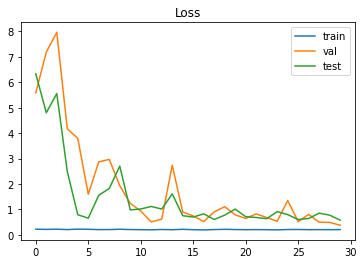

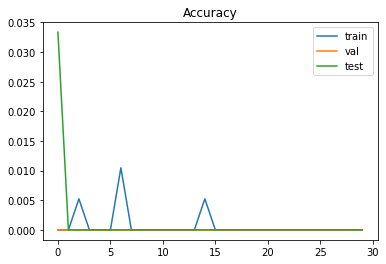

In [ ]:
# device = dev
lr = 0.0001
epochs = 30

#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0001)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
triplet_loss = TripletLoss(margin=0.2)

# initialize loss and accuracy values
history_loss = {"train": [], "val": [], "test": []}
history_accuracy = {"train": [], "val": [], "test": []}
best_val_accuracy = 0
test_accuracy_at_best_val = 0

try:

  for epoch in range(epochs):
    sum_loss = {"train": 0, "val": 0, "test": 0}
    loss_count = {"train": 0, "val": 0, "test": 0}
    sum_accuracy = {"train": 0, "val": 0, "test": 0}
    accuracy_count = {"train": 0, "val": 0, "test": 0}

    for split in ["train", "val", "test"]:
      if split == 'train':
        model = model.train()
        torch.set_grad_enabled(True)

      else:
        model.eval()
        torch.set_grad_enabled(False)

      for i,(images, labels) in enumerate(loaders[split]):

        # take a random anchor
        images = images.tolist()
        labels = labels.tolist()
        
        positive_list = []
        negative_list = []
        # print(type(images))
        # può verificarsi il caso in cui non vi siano positivi nel dataset poiché
        # i samples sono stati divisi dopo uno shuffle, quindi verifico che la 
        # postive list contenga dei valori, altrimenti ripeto la25 scelta random
        while not positive_list:
          anchor = random.choice(images)
          batch_index = images.index(anchor)
          #print(batch_index)
          label = labels[batch_index]
          anchor = torch.Tensor(anchor).to(device)

          # take the dataset index of the anchor
          past_elements = i*len(images)
          anchor_index = past_elements + batch_index
          
          # get positives and negatives lists
          positive_list = get_positive_list(split, label, anchor_index)

        negative_list = get_negative_list(split, label)

        # get hardest_negative and hardest_positive
        #print(anchor)
        anchor_out = model(anchor.unsqueeze(0)).to(device)
        positive = get_hard_pos(split, anchor_out, positive_list, label, model, device).to(device)
        negative = get_hard_neg(split, anchor_out, negative_list, label, model, device).to(device)

        # Compute output
        positive_out = model(positive.unsqueeze(0)).to(device)
        negative_out = model(negative.unsqueeze(0)).to(device)

        # Compute Loss
        loss = triplet_loss(anchor_out, positive_out, negative_out)
        # Update loss
        sum_loss[split] += loss.item()
        loss_count[split] += 1

        # Compute accuracy 
        pred_label = anchor_out.argmax(1)
        '''
        print(f"pred label: {pred_label}")
        print(f"correct label: {label}")
        print(type(pred_label))
        '''
        # print(pred_labels)
        correct = pred_label.eq(label).sum().item()
        #if pred_label == label:
        #  correct[split] += 1
        # print(correct)
        #batch_accuracy = correct/anchor.size(0)
        #sum_accuracy[split] += batch_accuracy
        sum_accuracy[split] += correct
        accuracy_count[split] += 1

        if split == 'train':
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

    # Compute epoch loss
    epoch_loss = {split: sum_loss[split]/loss_count[split] for split in ["train", "val", "test"]}
    epoch_accuracy = {split: sum_accuracy[split]/accuracy_count[split] for split in ["train", "val", "test"]}
    #epoch_accuracy = {split: correct[split]/accuracy_count[split] for split in ["train", "val", "test"]}
    # Update history
    for split in ["train", "val", "test"]:
      history_loss[split].append(epoch_loss[split])
      history_accuracy[split].append(epoch_accuracy[split])

    # Print info
    print("----------------------------------------------------------------------")
    print(f"Epoch {epoch+1}:",
          f"TrL={epoch_loss['train']:.4f},",
          f"TrA={epoch_accuracy['train']:.4f},",
          f"VL={epoch_loss['val']:.4f},",
          f"VA={epoch_accuracy['val']:.4f},",
          f"TeL={epoch_loss['test']:.4f},",
          f"TeA={epoch_accuracy['test']:.4f},")
    print("----------------------------------------------------------------------")

    if epoch_accuracy['val'] > best_val_accuracy:
      best_val_accuracy = epoch_accuracy['val']
      test_accuracy_at_best_val = epoch_accuracy['test']

except KeyboardInterrupt:
    print("Interrupted")
finally:
    print(f"Final val accuracy: {best_val_accuracy:.4f}")
    print(f"Final test accuracy: {test_accuracy_at_best_val:.4f}")
    # Plot loss
    plt.title("Loss")
    for split in ["train", "val", "test"]:
      plt.plot(history_loss[split], label=split)
    plt.legend()
    plt.show()
    # Plot accuracy
    plt.title("Accuracy")
    for split in ["train", "val", "test"]:
      plt.plot(history_accuracy[split], label=split)
    plt.legend()
    plt.show()